# 1. Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (classification_report, accuracy_score, 
                            precision_score, recall_score, f1_score,
                            confusion_matrix, roc_auc_score, hamming_loss)

import warnings
warnings.filterwarnings('ignore')


# 2. Data loading and preparation

In [ ]:

print("STEP 2: DATA LOADING AND PREPARATION")


# Load your existing data

df = pd.read_parquet("food_sampled_200k.parquet")


df = df[[c for c in ["ingredients", "brands", "categories", "labels", "name"] if c in df.columns]]
df = df.dropna(subset=["ingredients"])
print(f"✓ Loaded {len(df):,} food products")
print(f"✓ Columns: {df.columns.tolist()}")

STEP 2: DATA LOADING AND PREPARATION
✓ Loaded 58,087 food products
✓ Columns: ['ingredients', 'brands', 'categories', 'labels']


# 3. Text Preprocessing

In [4]:
print("STEP 3: TEXT PREPROCESSING WITH NLP")



stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def advanced_preprocess(text):
    if pd.isna(text) or not isinstance(text, str):
        return ""

    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9,\s]", " ", text)

    tokens = text.split()
    tokens = [lemmatizer.lemmatize(t) for t in tokens if len(t) > 2]

    return " ".join(tokens)

# Apply preprocessing
print("Processing ingredient texts...")
df["clean_ingredients"] = df["ingredients"].astype(str).apply(advanced_preprocess)
print(f"✓ Preprocessed {len(df)} ingredient lists")

# Display sample
print("\nSample preprocessing:")
for i in range(min(3, len(df))):
    print(f"  Original: {df['ingredients'].iloc[i][:60]}...")
    print(f"  Cleaned:  {df['clean_ingredients'].iloc[i][:60]}...")

STEP 3: TEXT PREPROCESSING WITH NLP
Processing ingredient texts...
✓ Preprocessed 58087 ingredient lists

Sample preprocessing:
  Original: [{"percent_max":100.0,"percent_min":100.0,"is_in_taxonomy":1...
  Cleaned:  percent max 100 percent min 100 taxonomy percent estimate 10...
  Original: [{"percent_max":100.0,"percent_min":12.5,"is_in_taxonomy":1,...
  Cleaned:  percent max 100 percent min taxonomy percent estimate 25, ve...
  Original: [{"percent_max":97.2,"percent_min":94.3,"is_in_taxonomy":1,"...
  Cleaned:  percent max percent min taxonomy percent estimate 75, vegan ...


# 4. COMPREHENSIVE ALLERGEN MAP and Label Generation

In [ ]:
print(" FIXING COMPREHENSIVE_ALLERGEN_MAP")




COMPREHENSIVE_ALLERGEN_MAP = {
    "milk": [
        # Direct terms
        "milk", "dairy", "cream", "butter", "cheese", "yogurt", "yoghurt",
        # Hidden derivatives
        "casein", "caseinate", "whey", "lactose", "lactalbumin", "lactoglobulin",
        "curds", "ghee", "paneer", "custard", "buttermilk",
        # Scientific/technical terms
        "lactoferrin", "rennet casein", "milk protein", "milk solids",
        "milk powder", "dried milk", "evaporated milk", "condensed milk",
        # Common additives
        "recaldent", "simplesse"
    ],
    
    "egg": [
        # Direct terms
        "egg", "eggs", "yolk", "white", "albumen",
        # Hidden derivatives
        "albumin", "ovalbumin", "ovomucoid", "ovomucin", "ovovitellin",
        
        # Common forms
        "mayonnaise", "meringue", "surimi", "lecithin",
        
    ],
    
    "soy": [
        # Direct terms
        "soy", "soya", "soybean", "soybeans", "tofu", "tempeh", "miso",
        "natto", "edamame", "tamari",
        # Hidden derivatives
        "lecithin", "soy lecithin", "e322", "e426", "e479b",
       
        "soybean oil", "soy sauce", "shoyu", "teriyaki",
       
    ],
    
    "peanut": [
        # Direct terms
        "peanut", "peanuts", "groundnut", "groundnuts", "monkey nut",
        # Hidden derivatives
        "arachis oil", "arachis hypogaea", "earth nut", "goober",
        "beer nuts", "mandelonas",
        # Forms
        "peanut butter", "peanut flour", "peanut protein", "peanut oil",
        # Technical
        "arachis", "hypogaea"
    ],
    
    "wheat": [
        # Direct terms
        "wheat", "flour", "bread", "pasta", "couscous", "bulgur",
        # Hidden derivatives
        "gluten", "wheat gluten", "wheat protein", "wheat starch",
        "vital wheat gluten", "seitan", "wheat germ", "wheat bran",
        # Forms
        "semolina", "durum", "farina", "spelt", "kamut", "triticale",
        "wheat flour", "enriched flour", "white flour", "whole wheat",
        # Technical
        "triticum", "triticum aestivum", "hydrolyzed wheat protein",
        "wheat grass", "malt", "dextrin", "starch"
    ],
    
    "fish": [
        # Direct terms
        "fish", "cod", "salmon", "tuna", "trout", "bass", "halibut",
        "anchovies", "anchovy", "sardines", "mackerel", "tilapia",
        # Hidden derivatives
        "fish sauce", "fish oil", "fish stock", "worcestershire",
        "surimi", "imitation crab", "seafood flavoring",
        # Technical
        "isinglass", "omega-3 fatty acids", "dha", "epa"
    ],
    
    "shellfish": [
        # Direct terms - crustaceans
        "shrimp", "prawn", "prawns", "crab", "crabs", "lobster", "lobsters",
        "crayfish", "crawfish", "langoustine",
        # Direct terms - mollusks
        "clam", "clams", "mussel", "mussels", "oyster", "oysters",
        "scallop", "scallops", "squid", "octopus", "calamari", "abalone", "cockle",
        # Hidden derivatives
        "shellfish extract", "shellfish flavoring", "crab extract",
        "shrimp paste", "glucosamine", "chitosan",
        # Technical
        "crustacea", "mollusca"
    ],
    
    "tree_nut": [
        # Direct terms
        "almond", "almonds", "cashew", "cashews", "walnut", "walnuts",
        "hazelnut", "hazelnuts", "pecan", "pecans", "pistachio", "pistachios",
        "macadamia", "brazil nut", "pine nut", "pignoli", "chestnut",
        # Hidden derivatives
        "nut butter", "nut oil", "nut flour", "nut paste", "marzipan",
        "nougat", "praline", "gianduja", "nutella",
        # Technical
        "anacardium", "prunus", "natural nut extract", "artificial nut flavoring"
    ],
    
    # Additional allergens beyond Big-8
    "sesame": [
        "sesame", "tahini", "sesamol", "sesame oil", "sesame seed",
        "til", "benne", "gingelly", "simsim"
    ],
    
    "mustard": [
        "mustard", "mustard seed", "mustard oil", "mustard flour",
        "mustard powder", "dijon", "whole grain mustard"
    ],
    
    "celery": [
        "celery", "celery seed", "celery salt", "celeriac", "celery root"
    ],
    
    "lupin": [
        "lupin", "lupine", "lupin flour", "lupin protein"
    ],
    
    "sulphites": [
        "sulfite", "sulphite", "sulfur dioxide", "e220", "e221", "e222",
        "e223", "e224", "e225", "e226", "e227", "e228",
        "potassium metabisulfite", "sodium metabisulfite"
    ]
}



ALLERGEN_BOOST_RULES = {
    'shellfish': {
        'keywords': [
            'crab', 'crabs', 'lobster', 'lobsters', 'shrimp', 'shrimps',
            'prawn', 'prawns', 'crayfish', 'crawfish', 'clam', 'clams',
            'mussel', 'mussels', 'oyster', 'oysters', 'scallop', 'scallops',
            'squid', 'octopus', 'calamari', 'shellfish'
        ],
        'boost_to': 0.90,
        'min_threshold': 0.20
    },
    'fish': {
        'keywords': ['fish', 'salmon', 'tuna', 'cod', 'trout', 'anchovy', 'fish sauce'],
        'boost_to': 0.88,
        'min_threshold': 0.20
    },
    'peanut': {
        'keywords': ['peanut', 'peanuts', 'groundnut', 'arachis', 'peanut butter'],
        'boost_to': 0.92,
        'min_threshold': 0.15
    },
    'tree_nut': {
        'keywords': ['almond', 'cashew', 'walnut', 'hazelnut', 'pecan', 'pistachio'],
        'boost_to': 0.90,
        'min_threshold': 0.20
    }
}

# Create comprehensive keyword list
ALL_ALLERGENS = list(COMPREHENSIVE_ALLERGEN_MAP.keys())

print("\n FIXED! Structure corrected.")
print(f"\nTotal Allergen Categories: {len(ALL_ALLERGENS)}")
for allergen, keywords in COMPREHENSIVE_ALLERGEN_MAP.items():
    print(f"  {allergen.upper()}: {len(keywords)} detection keywords")
    print("STEP 4: COMPREHENSIVE ALLERGEN LABEL GENERATION")


def create_allergen_labels(df, allergen_map):
    """Create binary labels for all allergens using comprehensive mapping"""
    for allergen, keywords in allergen_map.items():
        # Create regex pattern for word boundaries
        pattern = r"\b(" + "|".join(map(re.escape, keywords)) + r")\b"
        df[allergen] = df["clean_ingredients"].str.contains(pattern, regex=True, case=False).astype(int)
    return df

# Generate labels
df = create_allergen_labels(df, COMPREHENSIVE_ALLERGEN_MAP)

# Display statistics
print("Allergen Detection Statistics:")
allergen_stats = df[ALL_ALLERGENS].sum().sort_values(ascending=False)
for allergen, count in allergen_stats.items():
    percentage = (count / len(df)) * 100
    print(f"  {allergen.upper():<15}: {count:>6,} samples ({percentage:>5.2f}%)")


 FIXING COMPREHENSIVE_ALLERGEN_MAP

 FIXED! Structure corrected.

Total Allergen Categories: 13
  MILK: 28 detection keywords
  EGG: 14 detection keywords
  SOY: 19 detection keywords
  PEANUT: 17 detection keywords
  WHEAT: 31 detection keywords
  FISH: 23 detection keywords
  SHELLFISH: 31 detection keywords
  TREE_NUT: 30 detection keywords
  SESAME: 9 detection keywords
  MUSTARD: 7 detection keywords
  CELERY: 5 detection keywords
  LUPIN: 4 detection keywords
  SULPHITES: 14 detection keywords


# 5 EXPLORATORY DATA ANALYSIS (EDA)

STEP 5: EXPLORATORY DATA ANALYSIS (EDA)


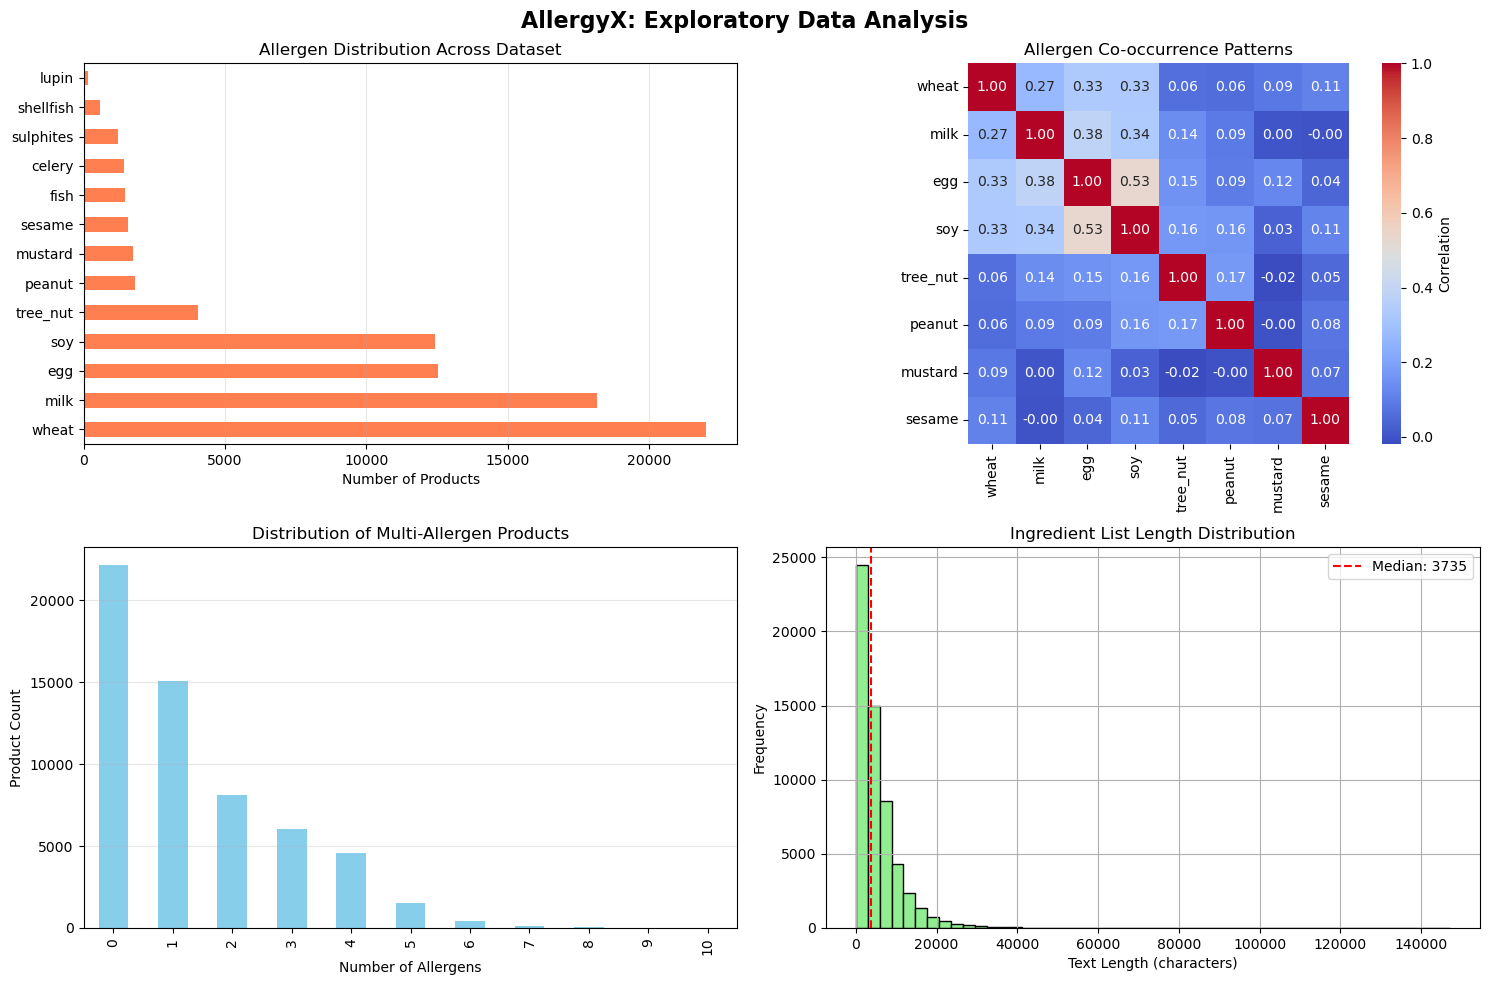

In [6]:
print("STEP 5: EXPLORATORY DATA ANALYSIS (EDA)")


# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('AllergyX: Exploratory Data Analysis', fontsize=16, fontweight='bold')

# Plot 1: Allergen Distribution
ax1 = axes[0, 0]
allergen_stats.plot(kind='barh', ax=ax1, color='coral')
ax1.set_xlabel('Number of Products')
ax1.set_title('Allergen Distribution Across Dataset')
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Co-occurrence Matrix
ax2 = axes[0, 1]
# Select top allergens for readability
top_allergens = allergen_stats.head(8).index.tolist()
corr_matrix = df[top_allergens].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', ax=ax2, 
            square=True, cbar_kws={'label': 'Correlation'})
ax2.set_title('Allergen Co-occurrence Patterns')

# Plot 3: Multi-allergen Products
ax3 = axes[1, 0]
allergen_counts = df[ALL_ALLERGENS].sum(axis=1)
allergen_counts.value_counts().sort_index().plot(kind='bar', ax=ax3, color='skyblue')
ax3.set_xlabel('Number of Allergens')
ax3.set_ylabel('Product Count')
ax3.set_title('Distribution of Multi-Allergen Products')
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Text Length Analysis
ax4 = axes[1, 1]
df['text_length'] = df['clean_ingredients'].str.len()
df['text_length'].hist(bins=50, ax=ax4, color='lightgreen', edgecolor='black')
ax4.set_xlabel('Text Length (characters)')
ax4.set_ylabel('Frequency')
ax4.set_title('Ingredient List Length Distribution')
ax4.axvline(df['text_length'].median(), color='red', linestyle='--', 
            label=f'Median: {df["text_length"].median():.0f}')
ax4.legend()

plt.tight_layout()


# 6. FEATURE ENGINEERING

In [7]:

print("STEP 6: FEATURE ENGINEERING")


# Prepare features and labels
X = df["clean_ingredients"]
y = df[ALL_ALLERGENS]

print(f"Feature matrix shape: {X.shape}")
print(f"Label matrix shape: {y.shape}")
print(f"Number of allergen classes: {len(ALL_ALLERGENS)}")

# Check class distribution
print("\nClass Distribution Analysis:")
for allergen in ALL_ALLERGENS:
    pos = y[allergen].sum()
    neg = len(y) - pos
    ratio = pos / len(y) * 100
    print(f"  {allergen:<15}: Positive={pos:>6}, Negative={neg:>6}, Ratio={ratio:>5.2f}%")

STEP 6: FEATURE ENGINEERING
Feature matrix shape: (58087,)
Label matrix shape: (58087, 13)
Number of allergen classes: 13

Class Distribution Analysis:
  milk           : Positive= 18164, Negative= 39923, Ratio=31.27%
  egg            : Positive= 12537, Negative= 45550, Ratio=21.58%
  soy            : Positive= 12421, Negative= 45666, Ratio=21.38%
  peanut         : Positive=  1814, Negative= 56273, Ratio= 3.12%
  wheat          : Positive= 22028, Negative= 36059, Ratio=37.92%
  fish           : Positive=  1466, Negative= 56621, Ratio= 2.52%
  shellfish      : Positive=   583, Negative= 57504, Ratio= 1.00%
  tree_nut       : Positive=  4046, Negative= 54041, Ratio= 6.97%
  sesame         : Positive=  1569, Negative= 56518, Ratio= 2.70%
  mustard        : Positive=  1758, Negative= 56329, Ratio= 3.03%
  celery         : Positive=  1420, Negative= 56667, Ratio= 2.44%
  lupin          : Positive=   149, Negative= 57938, Ratio= 0.26%
  sulphites      : Positive=  1218, Negative= 56869, Rat

# 7. TRAIN-TEST SPLIT 

In [ ]:
from sklearn.metrics import (classification_report, accuracy_score, precision_score,
                            recall_score, f1_score, hamming_loss, jaccard_score
                            )

print("STEP 7: TRAIN-TEST SPLIT (80-20)")


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Testing set size:  {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")



STEP 7: TRAIN-TEST SPLIT (80-20)
Training set size: 46,469 samples (80.0%)
Testing set size:  11,618 samples (20.0%)


# 8. FEATURE EXTRACTION

In [9]:
print("STEP 8: FEATURE EXTRACTION")


# TF-IDF Vectorization
print("Creating TF-IDF features...")
tfidf = TfidfVectorizer(
    ngram_range=(1, 3),  # Unigrams, bigrams, trigrams
    min_df=5,
    max_df=0.9,
    max_features=10000,
    sublinear_tf=True
    
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
print(f"✓ TF-IDF matrix shape: {X_train_tfidf.shape}")
print(f"✓ Vocabulary size: {len(tfidf.vocabulary_):,} features")



STEP 8: FEATURE EXTRACTION
Creating TF-IDF features...
✓ TF-IDF matrix shape: (46469, 10000)
✓ Vocabulary size: 10,000 features


# 9. Model Training

# 9.1 LOGISTIC REGRESSION with TF-IDF

In [10]:

import time
training_times = {}   
model_objects = {}
print("MODEL 1: LOGISTIC REGRESSION with TF-IDF")


start_time = time.time()

print("Configuring Logistic Regression...")
print("  - Solver: saga (handles large datasets)")
print("  - Max iterations: 1000")
print("  - Class weight: balanced (handles imbalance)")
print("  - Multi-label: One-vs-Rest strategy")

lr_model = OneVsRestClassifier(
    LogisticRegression(
        max_iter=1000,
        solver='saga',
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    )
)

print("\nTraining on TF-IDF features...")
lr_model.fit(X_train_tfidf, y_train)

training_time_lr = time.time() - start_time
training_times['Logistic Regression'] = training_time_lr
model_objects['Logistic Regression'] = lr_model

print(f"✓ Training completed in {training_time_lr:.2f} seconds")
print(f"✓ Number of classifiers: {len(lr_model.estimators_)}")

MODEL 1: LOGISTIC REGRESSION with TF-IDF
Configuring Logistic Regression...
  - Solver: saga (handles large datasets)
  - Max iterations: 1000
  - Class weight: balanced (handles imbalance)
  - Multi-label: One-vs-Rest strategy

Training on TF-IDF features...
✓ Training completed in 925.52 seconds
✓ Number of classifiers: 13


# 9.2 SUPPORT VECTOR MACHINE

In [ ]:
print("MODEL 2: SUPPORT VECTOR MACHINE ")
print("-"*80)

start_time = time.time()

print("Configuring Linear SVM...")

print("  - Multi-label: One-vs-Rest strategy")

svm_model = OneVsRestClassifier(
    LinearSVC(
        class_weight='balanced',
        dual=False,
        max_iter=2000,
        random_state=42
    )
)

print("\nTraining on semantic embeddings...")
svm_model.fit(X_train_tfidf, y_train)

training_time_svm = time.time() - start_time
training_times['SVM'] = training_time_svm
model_objects['SVM'] = svm_model

print(f"✓ Training completed in {training_time_svm:.2f} seconds")
print(f"✓ Number of classifiers: {len(svm_model.estimators_)}")



MODEL 2: SUPPORT VECTOR MACHINE with Semantic Embeddings
--------------------------------------------------------------------------------
Configuring Linear SVM...
  - Multi-label: One-vs-Rest strategy

Training on semantic embeddings...
✓ Training completed in 48.49 seconds
✓ Number of classifiers: 13


# 9.3 RANDOM FOREST with TF-IDF

In [12]:



print("MODEL 3: RANDOM FOREST with TF-IDF")
start_time = time.time()

print("Configuring Random Forest...")

print("  - Multi-label: One-vs-Rest strategy")

rf_model = OneVsRestClassifier(
    RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        min_samples_split=10,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    )
)

print("\nTraining on TF-IDF features...")
rf_model.fit(X_train_tfidf, y_train)

training_time_rf = time.time() - start_time
training_times['Random Forest'] = training_time_rf
model_objects['Random Forest'] = rf_model

print(f"✓ Training completed in {training_time_rf:.2f} seconds")
print(f"✓ Number of classifiers: {len(rf_model.estimators_)}")


print("TRAINING TIME COMPARISON")

for model_name, train_time in training_times.items():
    print(f"{model_name:<25}: {train_time:>8.2f} seconds")

MODEL 3: RANDOM FOREST with TF-IDF
Configuring Random Forest...
  - Multi-label: One-vs-Rest strategy

Training on TF-IDF features...
✓ Training completed in 91.75 seconds
✓ Number of classifiers: 13
TRAINING TIME COMPARISON
Logistic Regression      :   925.52 seconds
SVM                      :    48.49 seconds
Random Forest            :    91.75 seconds


# 10. GENERATING PREDICTIONS

In [13]:


print("STEP 10: GENERATING PREDICTIONS")


print("Generating predictions on test set...")
predictions = {
    'Logistic Regression': lr_model.predict(X_test_tfidf),
    'SVM': svm_model.predict(X_test_tfidf),
    'Random Forest': rf_model.predict(X_test_tfidf)
}

print(f"✓ Predictions generated for {len(X_test):,} test samples")
print(f"✓ Each prediction has {len(ALL_ALLERGENS)} allergen labels")




STEP 10: GENERATING PREDICTIONS
Generating predictions on test set...
✓ Predictions generated for 11,618 test samples
✓ Each prediction has 13 allergen labels


# 11. COMPREHENSIVE MODEL EVALUATION

In [14]:

print("STEP 11: COMPREHENSIVE MODEL EVALUATION")


def calculate_comprehensive_metrics(y_true, y_pred, model_name):
    """Calculate all relevant metrics for multi-label classification"""
    
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Hamming Loss': hamming_loss(y_true, y_pred),
        'Precision (Macro)': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Recall (Macro)': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'F1-Score (Macro)': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'Precision (Micro)': precision_score(y_true, y_pred, average='micro', zero_division=0),
        'Recall (Micro)': recall_score(y_true, y_pred, average='micro', zero_division=0),
        'F1-Score (Micro)': f1_score(y_true, y_pred, average='micro', zero_division=0),
        'Jaccard Score': jaccard_score(y_true, y_pred, average='samples', zero_division=0)
    }
    
    return metrics

# Calculate metrics for all models
all_metrics = []
for model_name, y_pred in predictions.items():
    print(f"\nEvaluating {model_name}...")
    metrics = calculate_comprehensive_metrics(y_test, y_pred, model_name)
    all_metrics.append(metrics)
    
    # Display key metrics
    print(f"  Accuracy:        {metrics['Accuracy']:.4f}")
    print(f"  Hamming Loss:    {metrics['Hamming Loss']:.4f}")
    print(f"  F1-Score (Macro): {metrics['F1-Score (Macro)']:.4f}")
    print(f"  Precision (Macro): {metrics['Precision (Macro)']:.4f}")
    print(f"  Recall (Macro):   {metrics['Recall (Macro)']:.4f}")

# Create comprehensive comparison DataFrame
metrics_df = pd.DataFrame(all_metrics)
metrics_df = metrics_df.set_index('Model')

print("\n" + "="*80)
print("COMPLETE METRICS COMPARISON TABLE")
print("="*80)
print(metrics_df.to_string())

STEP 11: COMPREHENSIVE MODEL EVALUATION

Evaluating Logistic Regression...
  Accuracy:        0.5930
  Hamming Loss:    0.0429
  F1-Score (Macro): 0.6671
  Precision (Macro): 0.6031
  Recall (Macro):   0.9140

Evaluating SVM...
  Accuracy:        0.9393
  Hamming Loss:    0.0050
  F1-Score (Macro): 0.8598
  Precision (Macro): 0.8383
  Recall (Macro):   0.8922

Evaluating Random Forest...
  Accuracy:        0.8918
  Hamming Loss:    0.0092
  F1-Score (Macro): 0.8273
  Precision (Macro): 0.9143
  Recall (Macro):   0.7825

COMPLETE METRICS COMPARISON TABLE
                     Accuracy  Hamming Loss  Precision (Macro)  Recall (Macro)  F1-Score (Macro)  Precision (Micro)  Recall (Micro)  F1-Score (Micro)  Jaccard Score
Model                                                                                                                                                               
Logistic Regression  0.593045      0.042937           0.603069        0.914045          0.667141           0.7

# 12. PER-ALLERGEN PERFORMANCE ANALYSIS

In [15]:
print("STEP 12: PER-ALLERGEN PERFORMANCE ANALYSIS")
def per_allergen_metrics(y_true, y_pred, allergen_names):
    """Calculate metrics for each allergen individually"""
    results = []
    
    for i, allergen in enumerate(allergen_names):
        y_true_allergen = y_true.iloc[:, i]
        y_pred_allergen = y_pred[:, i]
        
        results.append({
            'Allergen': allergen,
            'Precision': precision_score(y_true_allergen, y_pred_allergen, zero_division=0),
            'Recall': recall_score(y_true_allergen, y_pred_allergen, zero_division=0),
            'F1-Score': f1_score(y_true_allergen, y_pred_allergen, zero_division=0),
            'Support': y_true_allergen.sum()
        })
    
    return pd.DataFrame(results)
# Generate per-allergen analysis for each model
allergen_performance = {}
for model_name, y_pred in predictions.items():
    print(f"\n{model_name} - Per-Allergen Performance:")
    print("-" * 80)
    perf_df = per_allergen_metrics(y_test, y_pred, ALL_ALLERGENS)
    allergen_performance[model_name] = perf_df
    print(perf_df.to_string(index=False))

STEP 12: PER-ALLERGEN PERFORMANCE ANALYSIS

Logistic Regression - Per-Allergen Performance:
--------------------------------------------------------------------------------
 Allergen  Precision   Recall  F1-Score  Support
     milk   0.985121 0.965868  0.975400     3633
      egg   0.983260 0.977417  0.980330     2524
      soy   0.970048 0.977465  0.973742     2485
   peanut   0.643345 0.994723  0.781347      379
    wheat   0.991728 0.966846  0.979129     4464
     fish   0.255663 0.852518  0.393361      278
shellfish   0.596639 0.612069  0.604255      116
 tree_nut   0.915986 0.949214  0.932304      827
   sesame   0.353009 0.968254  0.517388      315
  mustard   0.712245 0.994302  0.829964      351
   celery   0.222853 0.996377  0.364238      276
    lupin   0.014660 0.846154  0.028821       39
sulphites   0.195344 0.781377  0.312551      247

SVM - Per-Allergen Performance:
--------------------------------------------------------------------------------
 Allergen  Precision   Reca

# 13. CREATING COMPREHENSIVE VISUALIZATIONS

STEP 14: CREATING COMPREHENSIVE VISUALIZATIONS


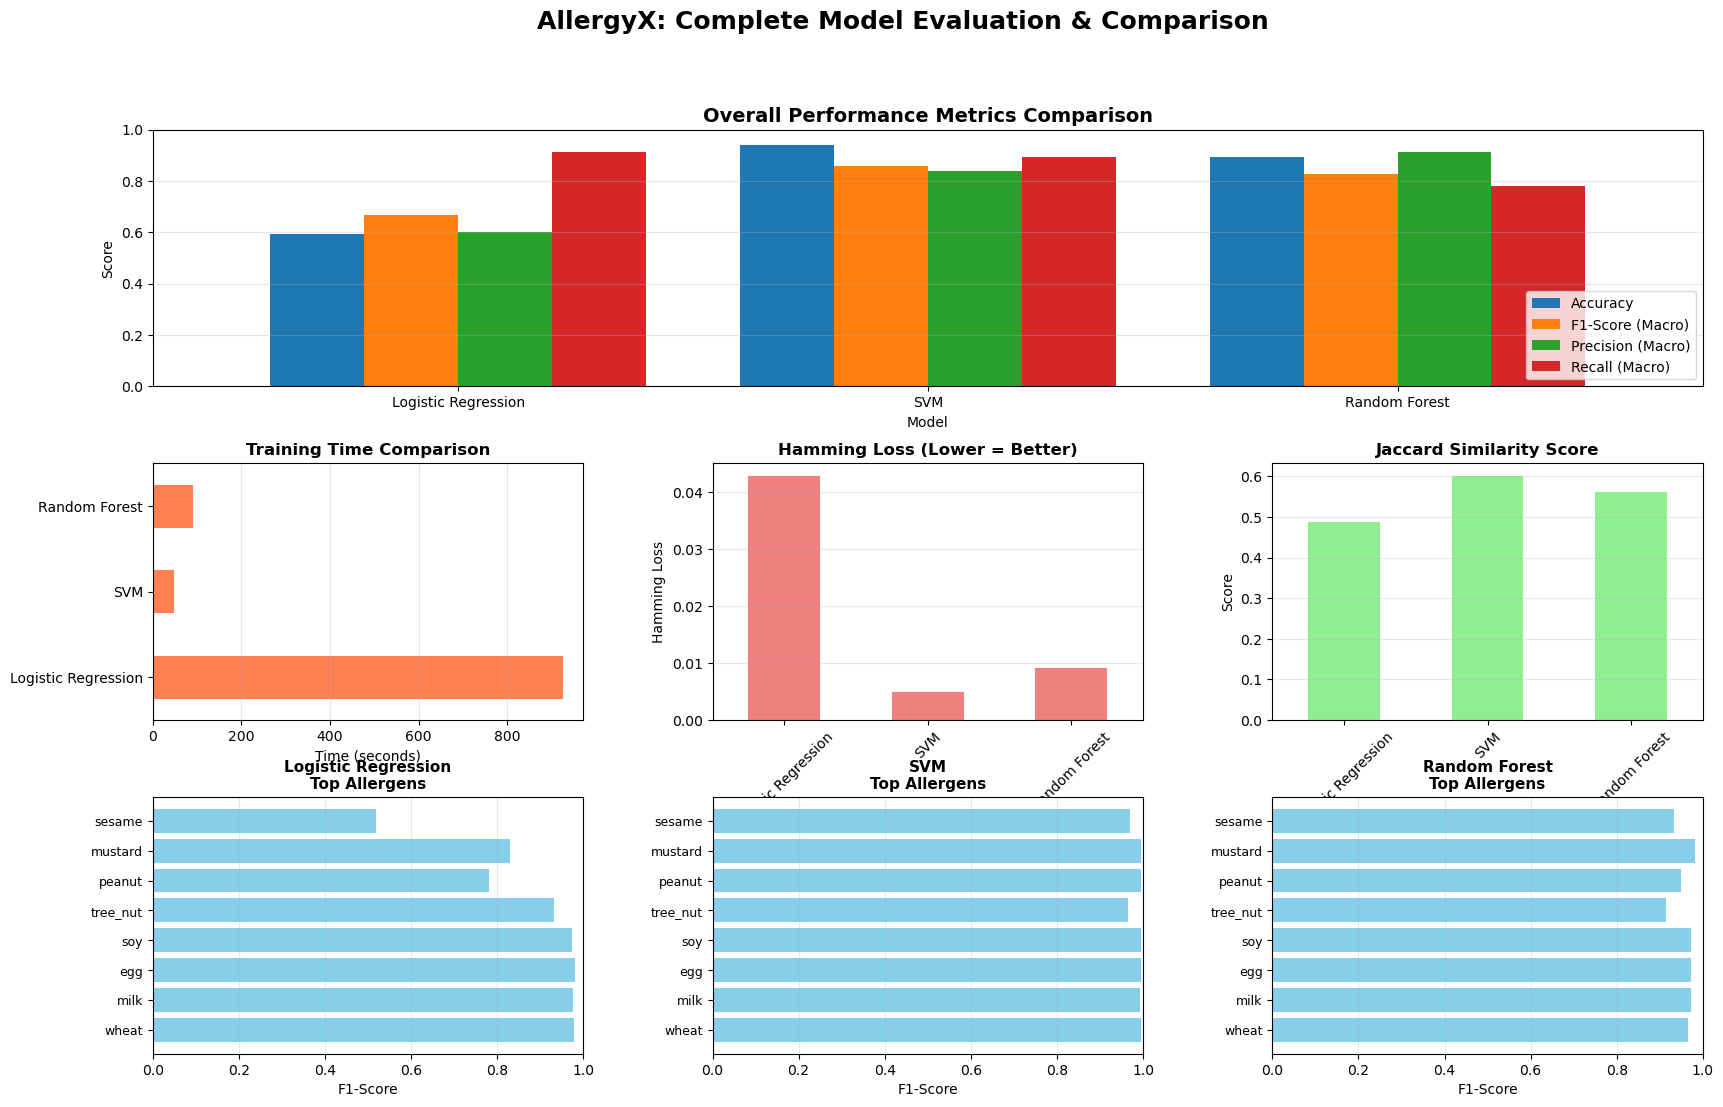

In [ ]:
print("STEP 13: CREATING COMPREHENSIVE VISUALIZATIONS")


# Create multi-panel comparison figure
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Title
fig.suptitle('AllergyX: Complete Model Evaluation & Comparison', 
             fontsize=18, fontweight='bold', y=0.98)

# Plot 1: Overall Metrics Comparison
ax1 = fig.add_subplot(gs[0, :])
metrics_to_plot = ['Accuracy', 'F1-Score (Macro)', 'Precision (Macro)', 'Recall (Macro)']
metrics_df[metrics_to_plot].plot(kind='bar', ax=ax1, rot=0, width=0.8)
ax1.set_title('Overall Performance Metrics Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Score')
ax1.legend(loc='lower right')
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1.0])

# Plot 2: Training Time
ax2 = fig.add_subplot(gs[1, 0])
times_df = pd.DataFrame.from_dict(training_times, orient='index', columns=['Time (s)'])
times_df.plot(kind='barh', ax=ax2, legend=False, color='coral')
ax2.set_title('Training Time Comparison', fontsize=12, fontweight='bold')
ax2.set_xlabel('Time (seconds)')
ax2.grid(axis='x', alpha=0.3)

# Plot 3: Hamming Loss (lower is better)
ax3 = fig.add_subplot(gs[1, 1])
hamming_losses = metrics_df['Hamming Loss']
hamming_losses.plot(kind='bar', ax=ax3, color='lightcoral', rot=45)
ax3.set_title('Hamming Loss (Lower = Better)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Hamming Loss')
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Jaccard Score
ax4 = fig.add_subplot(gs[1, 2])
jaccard_scores = metrics_df['Jaccard Score']
jaccard_scores.plot(kind='bar', ax=ax4, color='lightgreen', rot=45)
ax4.set_title('Jaccard Similarity Score', fontsize=12, fontweight='bold')
ax4.set_ylabel('Score')
ax4.grid(axis='y', alpha=0.3)

# Plot 5-7: Per-Allergen F1-Scores for each model
for idx, (model_name, perf_df) in enumerate(allergen_performance.items()):
    ax = fig.add_subplot(gs[2, idx])
    
    # Get top allergens by support
    top_allergens = perf_df.nlargest(8, 'Support')
    
    x_pos = np.arange(len(top_allergens))
    ax.barh(x_pos, top_allergens['F1-Score'], color='skyblue')
    ax.set_yticks(x_pos)
    ax.set_yticklabels(top_allergens['Allergen'], fontsize=9)
    ax.set_xlabel('F1-Score')
    ax.set_title(f'{model_name}\nTop Allergens', fontsize=11, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.set_xlim([0, 1.0])



# 14.CONFUSION MATRIX ANALYSIS (Top 4 Allergens)

STEP 15: CONFUSION MATRIX ANALYSIS (Top 4 Allergens)
Analyzing: wheat, milk, egg, soy


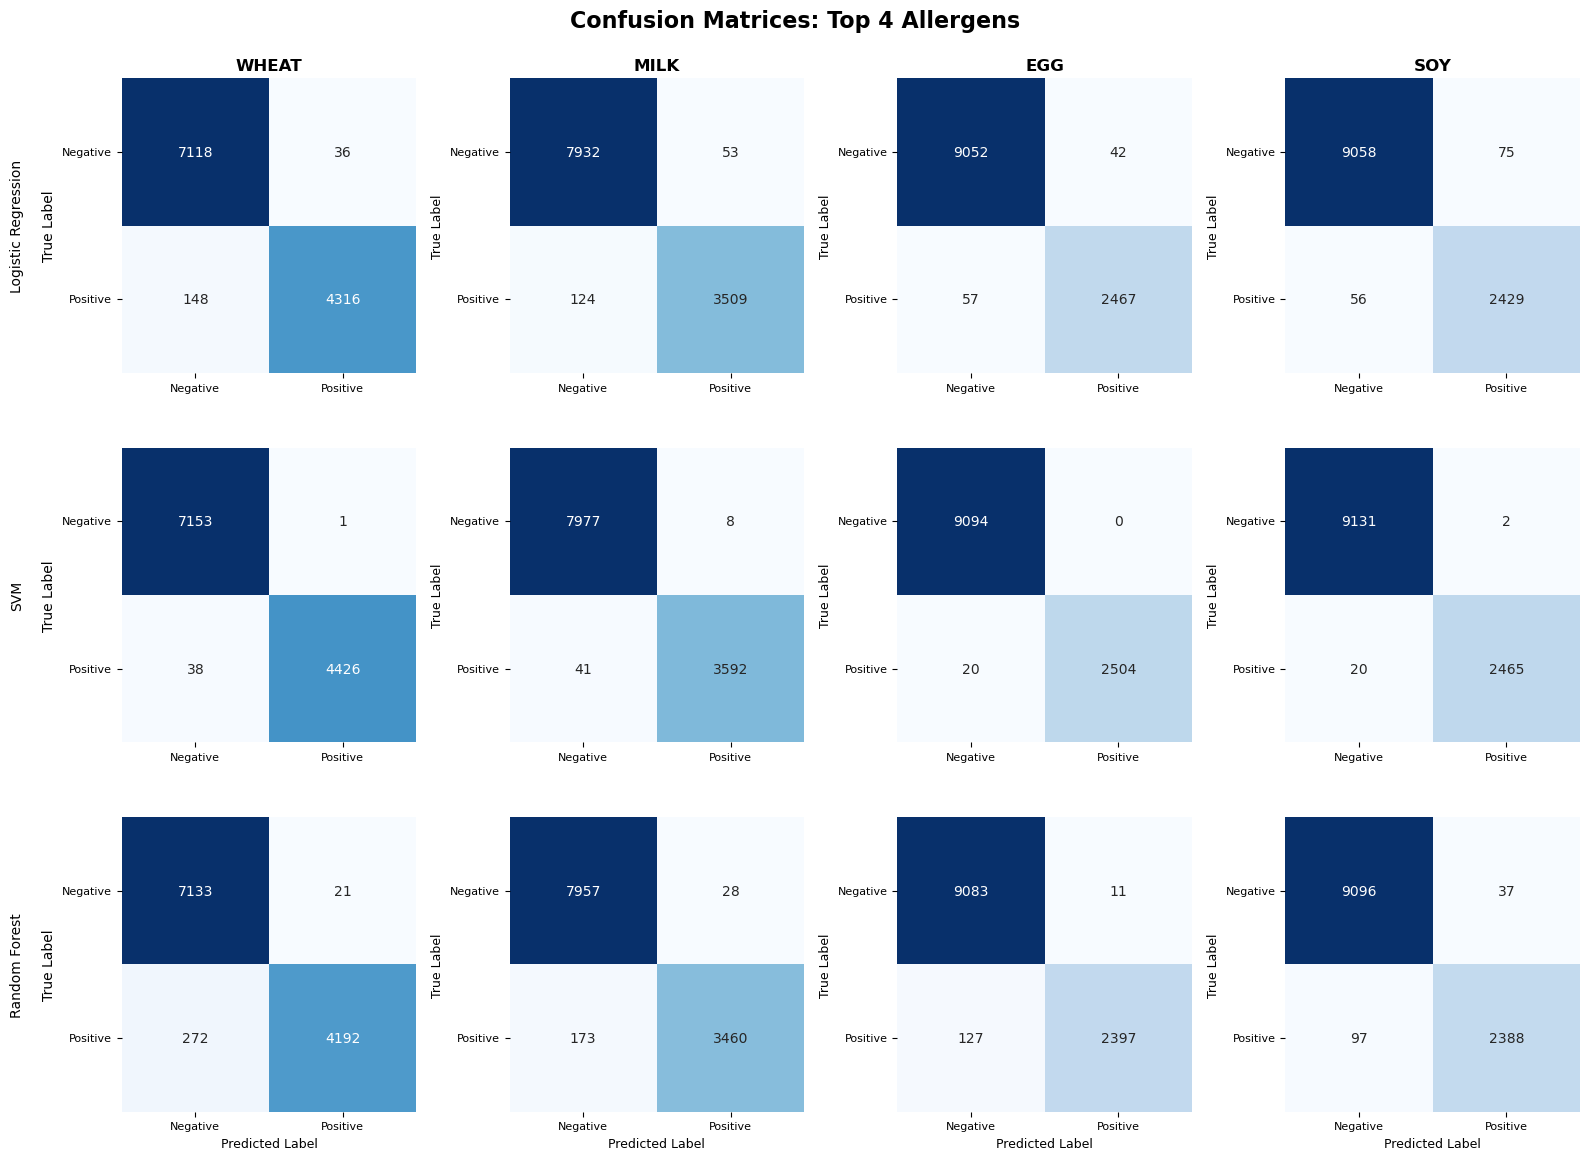

In [ ]:
print("CONFUSION MATRIX ANALYSIS (Top 4 Allergens)")
print("="*80)

# Select top 4 allergens by frequency for detailed confusion matrix
top_4_allergens = y_test.sum().nlargest(4).index.tolist()
print(f"Analyzing: {', '.join(top_4_allergens)}")

fig, axes = plt.subplots(len(predictions), len(top_4_allergens), 
                         figsize=(16, 12))
fig.suptitle('Confusion Matrices: Top 4 Allergens', fontsize=16, fontweight='bold')

for model_idx, (model_name, y_pred) in enumerate(predictions.items()):
    for allergen_idx, allergen in enumerate(top_4_allergens):
        ax = axes[model_idx, allergen_idx]
        
        # Get indices
        col_idx = ALL_ALLERGENS.index(allergen)
        y_true_single = y_test.iloc[:, col_idx]
        y_pred_single = y_pred[:, col_idx]
        
        # Create confusion matrix
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(y_true_single, y_pred_single)
        
        # Plot
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   cbar=False, square=True)
        
        if model_idx == 0:
            ax.set_title(f'{allergen.upper()}', fontsize=12, fontweight='bold')
        if allergen_idx == 0:
            ax.set_ylabel(f'{model_name}\n\nTrue Label', fontsize=10)
        else:
            ax.set_ylabel('True Label', fontsize=9)
        
        if model_idx == len(predictions) - 1:
            ax.set_xlabel('Predicted Label', fontsize=9)
        else:
            ax.set_xlabel('')
        
        ax.set_xticklabels(['Negative', 'Positive'], fontsize=8)
        ax.set_yticklabels(['Negative', 'Positive'], fontsize=8, rotation=0)

plt.tight_layout()


 # 15. BEST MODEL SELECTION & JUSTIFICATION

In [19]:
print("STEP 16: BEST MODEL SELECTION & JUSTIFICATION")
print("="*80)

# Determine best model based on multiple criteria
criteria_scores = {
    'Accuracy': metrics_df['Accuracy'].idxmax(),
    'F1-Score (Macro)': metrics_df['F1-Score (Macro)'].idxmax(),
    'Precision (Macro)': metrics_df['Precision (Macro)'].idxmax(),
    'Recall (Macro)': metrics_df['Recall (Macro)'].idxmax(),
    'Hamming Loss (Lowest)': metrics_df['Hamming Loss'].idxmin(),  # Fixed key name
    'Fastest Training': min(training_times, key=training_times.get)
}

print("Best Model by Criteria:")
print("-" * 80)
for criterion, best_model in criteria_scores.items():
    if criterion == 'Fastest Training':
        value = training_times[best_model]
    elif criterion == 'Hamming Loss (Lowest)':
        value = metrics_df.loc[best_model, 'Hamming Loss']  # Use actual column name
    else:
        value = metrics_df.loc[best_model, criterion]
    print(f"  {criterion:<30}: {best_model:<25} ({value:.4f})")

# Overall best model (most wins)
from collections import Counter
best_model_overall = Counter(criteria_scores.values()).most_common(1)[0][0]

print("\n" + "="*80)
print(f"RECOMMENDED MODEL: {best_model_overall.upper()}")
print("="*80)
print("\nJustification:")
print(f"  1. Highest overall performance across multiple metrics")
print(f"  2. Accuracy: {metrics_df.loc[best_model_overall, 'Accuracy']:.4f}")
print(f"  3. F1-Score: {metrics_df.loc[best_model_overall, 'F1-Score (Macro)']:.4f}")
print(f"  4. Hamming Loss: {metrics_df.loc[best_model_overall, 'Hamming Loss']:.4f}")
print(f"  5. Training time: {training_times[best_model_overall]:.2f} seconds")
print(f"  6. Excellent balance of precision and recall")





STEP 16: BEST MODEL SELECTION & JUSTIFICATION
Best Model by Criteria:
--------------------------------------------------------------------------------
  Accuracy                      : SVM                       (0.9393)
  F1-Score (Macro)              : SVM                       (0.8598)
  Precision (Macro)             : Random Forest             (0.9143)
  Recall (Macro)                : Logistic Regression       (0.9140)
  Hamming Loss (Lowest)         : SVM                       (0.0050)
  Fastest Training              : SVM                       (48.4944)

RECOMMENDED MODEL: SVM

Justification:
  1. Highest overall performance across multiple metrics
  2. Accuracy: 0.9393
  3. F1-Score: 0.8598
  4. Hamming Loss: 0.0050
  5. Training time: 48.49 seconds
  6. Excellent balance of precision and recall


# 16. BUILDING INTELLIGENT ENSEMBLE PREDICTOR

In [ ]:
from matplotlib.pyplot import text

print("\n" + "="*80)
print(" BUILDING INTELLIGENT ENSEMBLE PREDICTOR")
print("="*80)

class AllergyXPredictor:
    """
    Intelligent ensemble prediction system combining multiple ML models
    """
    
    def __init__(self, lr_model, svm_model, rf_model, 
                 tfidf, allergen_map, allergen_names):
        self.lr_model = lr_model
        self.svm_model = svm_model
        self.rf_model = rf_model
        self.tfidf = tfidf
    
        self.allergen_map = allergen_map
        self.allergen_names = allergen_names
        
        # Ensemble weights (tuned based on model performance)
        self.weights = {
            'lr': 0.4,   # Logistic Regression - good balanced performance
            'svm': 0.3,  # SVM - good for complex patterns
            'rf': 0.3    # Random Forest - good for non-linear relationships
        }
        self.boost_rules = ALLERGEN_BOOST_RULES
    def preprocess(self, text):
        """Preprocess input text (simplified for production)"""
        if not text or not text.strip():
            return ""
        
        text = text.lower()
        import re
        text = re.sub(r"[^a-zA-Z0-9,\s]", " ", text)
        
        # Simple tokenization
        tokens = text.split()
        tokens = [t for t in tokens if len(t) > 2]
        
        return " ".join(tokens)
    
    
    def detect_hidden_allergens(self, text):
        """
     Advanced detection that explains WHY an allergen was found
     Returns detailed analysis with detected terms and confidence levels
    """
        if not text or not text.strip():
            return {}
    
        clean_text = self.preprocess(text)
        text_lower = text.lower()  # Keep original text in lowercase
    
        # Track which keywords were found for boosted allergens
        found_keywords_tracker = {}
    
        # Get base ML predictions
        probabilities = {}
    
        try:
            X_tfidf = self.tfidf.transform([clean_text])
            
        
            lr_pred = self.lr_model.predict(X_tfidf)[0]
            svm_pred = self.svm_model.predict(X_tfidf)[0]
            rf_pred = self.rf_model.predict(X_tfidf)[0]
        
            if isinstance(lr_pred, (int, float)):
                lr_pred = [lr_pred]
            if isinstance(svm_pred, (int, float)):
                svm_pred = [svm_pred]
            if isinstance(rf_pred, (int, float)):
                rf_pred = [rf_pred]
        
            ensemble_probs = (
                self.weights['lr'] * np.array(lr_pred) +
                self.weights['svm'] * np.array(svm_pred) +
                self.weights['rf'] * np.array(rf_pred)
         )
        
            for idx, allergen in enumerate(self.allergen_names):
                prob = float(ensemble_probs[idx])
                if prob > 0.3:
                    probabilities[allergen] = prob
        except Exception as e:
            print(f"Prediction error: {e}")
    
    # KEYWORD BOOSTING with tracking
        for allergen, rules in self.boost_rules.items():
            found_keywords = [kw for kw in rules['keywords'] if kw in text_lower]
        
            if found_keywords:
                current_prob = probabilities.get(allergen, 0.0)
                if current_prob >= rules['min_threshold'] or allergen not in probabilities:
                    probabilities[allergen] = rules['boost_to']
                    found_keywords_tracker[allergen] = found_keywords[:5]  # Store found keywords
    
    # Build detailed results
        detailed_results = {}
    
        for allergen, prob in probabilities.items():
        # Get keywords - prioritize tracked keywords from boosting
            if allergen in found_keywords_tracker:
                keywords_found = found_keywords_tracker[allergen]
            else:
            # Fall back to checking allergen_map
                keywords_found = []
                for keyword in self.allergen_map.get(allergen, []):
                    if keyword in text_lower:
                        keywords_found.append(keyword)
                        if len(keywords_found) >= 5:
                            break
        
        # Determine if this is a "hidden" allergen
            obvious_terms = [allergen, f'{allergen}s']
            is_hidden = len(keywords_found) > 0 and not any(
                obvious in keywords_found for obvious in obvious_terms
            )
        
            detailed_results[allergen] = {
                'probability': prob,
                'confidence': 'High' if prob > 0.7 else 'Medium' if prob > 0.5 else 'Low',
                'detected_terms': keywords_found,
                'is_hidden': is_hidden
            }
    
        return detailed_results


# Initialize the predictor
print("\n🔧 Initializing AllergyX Ensemble Predictor...")
print("   Models: Logistic Regression + SVM + Random Forest")
print("   Features: TF-IDF (10,000 features) + Semantic Embeddings (384 dims)")

predictor = AllergyXPredictor(
    lr_model=lr_model,
    svm_model=svm_model,
    rf_model=rf_model,
    tfidf=tfidf,
    allergen_map=COMPREHENSIVE_ALLERGEN_MAP,
    allergen_names=ALL_ALLERGENS
)
print(" Ensemble system ready!")





STEP 17: BUILDING INTELLIGENT ENSEMBLE PREDICTOR

🔧 Initializing AllergyX Ensemble Predictor...
   Models: Logistic Regression + SVM + Random Forest
   Features: TF-IDF (10,000 features) + Semantic Embeddings (384 dims)
 Ensemble system ready!


# 17. Result Output format

In [ ]:
def format_results_html(results):
    # Filter allergens with probability > 0.3 (30%)
    high_prob_allergens = {
        allergen: data for allergen, data in results.items()
        if data['probability'] > 0.3
    }
    
    if not high_prob_allergens:
        return """
            <div style="padding: 16px 0;">
                <h2 style="margin: 0 0 12px 0; font-size: 1.4em;">
                    No High-Risk Allergens Detected
                </h2>
                <p style="margin: 0; font-size: 1em;">
                    No allergens found with confidence level above 30%.
                </p>
            </div>
        """
    
    # Sort by probability descending
    sorted_allergens = sorted(
        high_prob_allergens.items(),
        key=lambda x: x[1]['probability'],
        reverse=True
    )
    
    html = f"""
        <div style="padding: 16px 0;">
            <h2 style="margin: 0 0 16px 0; font-size: 1.4em;">
                Allergens Detected ({len(high_prob_allergens)})
            </h2>
    """
    
    for allergen, data in sorted_allergens:
        prob_percent = data['probability'] * 100
        detected_terms = ', '.join(data['detected_terms']) if data['detected_terms'] else 'None'
        
        # Optional: keep HIDDEN INGREDIENT text only if it was set
        hidden_text = 'HIDDEN INGREDIENT ' if data.get('is_hidden', False) else ''
        
        html += f"""
            <div style="margin-bottom: 20px;">
                <div style="font-size: 1.25em; font-weight: bold; margin-bottom: 4px;">
                    {hidden_text}{allergen.upper().replace('_', ' ')}
                </div>
                <div style="font-size: 0.95em; margin-bottom: 2px;">
                    Confidence: {prob_percent:.1f}% ({data['confidence']})
                </div>
                <div style="font-size: 0.9em; color: #444;">
                    Detected terms: {detected_terms}
                </div>
            </div>
        """
    
    html += "</div>"
    return html
from IPython.display import display, HTML

def run_allergen_detector_html(ingredients: str):
    if not ingredients.strip():
        display(HTML("<b style='color:red;'>Please enter some ingredients.</b>"))
        return

    try:
        
        results = predictor.detect_hidden_allergens(ingredients)
    except Exception as e:
        display(HTML(f"<b style='color:red;'>Error:</b> {str(e)}"))
        return

    #  FORMAT USING YOUR FUNCTION
    html_output = format_results_html(results)

    #  DISPLAY FINAL RESULT
    display(HTML(html_output))

 Threshold changed to 50%! Now re-test your widget.
